<h1><center><font size="6">Mô Hình Dự Báo Phát Hiện Gian Lận Giao Dịch Thẻ Tín Dụng</font></center></h1>

# <a id='0'>Mục Lục</a>

- <a href='#1'>Giới thiệu</a>  
- <a href='#2'>Tải các thư viện</a>  
- <a href='#3'>Đọc dữ liệu</a>  
- <a href='#4'>Kiểm tra dữ liệu</a>  
    - <a href='#41'>Xem nhanh dữ liệu</a>  
    - <a href='#42'>Kiểm tra dữ liệu thiếu</a>
    - <a href='#43'>Kiểm tra mức độ mất cân bằng</a>
- <a href='#5'>Khám phá dữ liệu</a>
- <a href='#6'>Các mô hình dự báo</a>  
    - <a href='#61'>RandomForrestClassifier</a> 
    - <a href='#62'>AdaBoostClassifier</a>     
    - <a href='#63'>CatBoostClassifier</a> 
    - <a href='#64'>XGBoost</a> 
    - <a href='#65'>LightGBM</a> 
- <a href='#7'>Kết luận</a>


# <a id="1">Giới thiệu</a>  

Bộ dữ liệu này bao gồm các giao dịch được thực hiện bằng thẻ tín dụng vào **tháng 9 năm 2013** bởi các chủ thẻ tại Châu Âu. Dữ liệu ghi nhận các giao dịch diễn ra trong vòng hai ngày, trong đó có **492 giao dịch gian lận** trên tổng số **284.807 giao dịch**. Bộ dữ liệu có mức độ **mất cân bằng rất cao**, khi **lớp dương (gian lận)** chỉ chiếm **0,172%** tổng số giao dịch.  

Bộ dữ liệu chỉ bao gồm các biến đầu vào dạng số – đây là kết quả của quá trình **biến đổi PCA**.  

Do các vấn đề về bảo mật, thông tin về các biến gốc cũng như bối cảnh dữ liệu không được cung cấp.  

* Các biến **V1**, **V2**, ... **V28** là các **thành phần chính** thu được từ **PCA**;  
* Hai biến duy nhất **không được biến đổi PCA** là **Time** và **Amount**.  
  * Biến **Time** biểu thị số giây trôi qua giữa mỗi giao dịch so với giao dịch đầu tiên trong bộ dữ liệu.  
  * Biến **Amount** là số tiền giao dịch, có thể được sử dụng cho các phương pháp học nhạy chi phí theo từng mẫu.  
* Biến **Class** là biến mục tiêu, nhận giá trị **1** nếu giao dịch là gian lận và **0** nếu ngược lại.  


# <a id="2">Tải các thư viện</a>

In [55]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# Thư viện hỗ trợ dọn dẹp bộ nhớ và xử lý thời gian
import gc
from datetime import datetime 

# Thư viện chia tập dữ liệu
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Thư viện metric đánh giá mô hình
from sklearn.metrics import roc_auc_score

# Các mô hình học máy
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb
import warnings
import joblib
warnings.filterwarnings('ignore')

# Tùy chỉnh hiển thị của pandas
pd.set_option('display.max_columns', 100)


# Tham số cho RandomForestClassifier
RFC_METRIC = 'gini'      # metric sử dụng cho RandomForest
NUM_ESTIMATORS = 100     # số lượng cây quyết định trong RandomForest
NO_JOBS = 4              # số lượng job chạy song song


# CHIA TẬP TRAIN / VALIDATION / TEST
# VALIDATION
VALID_SIZE = 0.20        # tỉ lệ chia validation bằng train_test_split
TEST_SIZE = 0.20         # tỉ lệ chia test bằng train_test_split

# CROSS-VALIDATION
NUMBER_KFOLDS = 5        # số lượng folds sử dụng trong K-Fold CV


RANDOM_STATE = 2018      # random seed dùng cố định kết quả

# THAM SỐ CHO LIGHTGBM
MAX_ROUNDS = 1000        # số vòng lặp huấn luyện LGBM
EARLY_STOP = 50          # vòng lặp dừng sớm (early stopping)
OPT_ROUNDS = 1000        # số vòng tối ưu (được điều chỉnh dựa vào validation)
VERBOSE_EVAL = 50        # in log sau mỗi 50 vòng

IS_LOCAL = False         # kiểm tra chạy local hay Kaggle kernel

import os

# Đường dẫn file dữ liệu
if(IS_LOCAL):
    PATH="../input/credit-card-fraud-detection"
else:
    PATH="../input"

print(os.listdir(PATH))  # in danh sách file trong thư mục input

['creditcard.csv']


# <a id="3">Đọc dữ liệu</a>

In [56]:
data_df = pd.read_csv(PATH+"/creditcard.csv")

# <a id="4">Kiểm tra dữ liệu</a>

In [57]:
print("Dữ liệu Phát Hiện Gian Lận Thẻ Tín Dụng – số dòng (rows):",data_df.shape[0]," columns:", data_df.shape[1])

Dữ liệu Phát Hiện Gian Lận Thẻ Tín Dụng – số dòng (rows): 284807  columns: 31


## <a id="41">Xem nhanh dữ liệu</a>

In [58]:
data_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [59]:
data_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.175161e-15,3.369007e-16,-1.379537e-15,2.094852e-15,1.021879e-15,1.500885e-15,-5.620335e-16,1.149614e-16,-2.426963e-15,2.240150e-15,1.724421e-15,-1.245415e-15,8.238900e-16,1.213481e-15,4.866699e-15,1.432227e-15,-3.768179e-16,9.707851e-16,1.036249e-15,6.386744e-16,1.596686e-16,-3.576577e-16,2.650499e-16,4.472317e-15,5.109395e-16,1.686100e-15,-3.662399e-16,-1.225457e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


## <a id="42">Kiểm tra dữ liệu thiếu</a>  


In [60]:
total = data_df.isnull().sum().sort_values(ascending = False)
percent = (data_df.isnull().sum()/data_df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,Time,V16,Amount,V28,V27,V26,V25,V24,V23,V22,V21,V20,V19,V18,V17,V15,V1,V14,V13,V12,V11,V10,V9,V8,V7,V6,V5,V4,V3,V2,Class
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## <a id="43">Kiểm tra mức độ mất cân bằng</a>

In [61]:
temp = data_df["Class"].value_counts()
df = pd.DataFrame({'Class': temp.index,'values': temp.values})

trace = go.Bar(
    x = df['Class'],y = df['values'],
    name="Phân lớp gian lận thẻ tín dụng – dữ liệu mất cân bằng (Không gian lận = 0, Gian lận = 1)",
    marker=dict(color="Red"),
    text=df['values']
)
data = [trace]
layout = dict(title = 'Phân lớp Gian Lận Thẻ Tín Dụng – Dữ Liệu Mất Cân Bằng (Không Gian Lận = 0, Gian Lận = 1)',
          xaxis = dict(title = 'Class', showticklabels=True), 
          yaxis = dict(title = 'Số lượng giao dịch'),
          hovermode = 'closest',width=600
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='class')

Chỉ có 492 giao dịch (tương đương 0,172%) là gian lận. Điều này cho thấy dữ liệu bị mất cân bằng nghiêm trọng đối với biến mục tiêu Class.

# <a id="5">Khám phá dữ liệu</a>

## Giao dịch theo thời gian

In [62]:
class_0 = data_df.loc[data_df['Class'] == 0]["Time"]
class_1 = data_df.loc[data_df['Class'] == 1]["Time"]

hist_data = [class_0, class_1]
group_labels = ['Not Fraud', 'Fraud']

fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
fig['layout'].update(title='Biểu đồ Mật độ Thời gian Giao dịch Thẻ Tín dụng', xaxis=dict(title='Time [s]'))
iplot(fig, filename='dist_only')

Phân bố của các giao dịch gian lận cho thấy mức độ đồng đều cao hơn đáng kể so với giao dịch hợp lệ; chúng xuất hiện xuyên suốt các mốc thời gian, kể cả trong những khung giờ đêm vốn có ít giao dịch thực tại khu vực Châu Âu.

In [63]:
data_df['Hour'] = data_df['Time'].apply(lambda x: np.floor(x / 3600))

tmp = data_df.groupby(['Hour', 'Class'])['Amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()
df = pd.DataFrame(tmp)
df.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
df.head()

,Hour,Class,Min,Max,Transactions,Sum,Mean,Median,Var
0,0.0,0,0.0,7712.43,3961,256572.87,64.774772,12.990,45615.821201
1,0.0,1,0.0,529.00,2,529.00,264.500000,264.500,139920.500000
2,1.0,0,0.0,1769.69,2215,145806.76,65.826980,22.820,20053.615770
3,1.0,1,59.0,239.93,2,298.93,149.465000,149.465,16367.832450
4,2.0,0,0.0,4002.88,1555,106989.39,68.803466,17.900,45355.430437


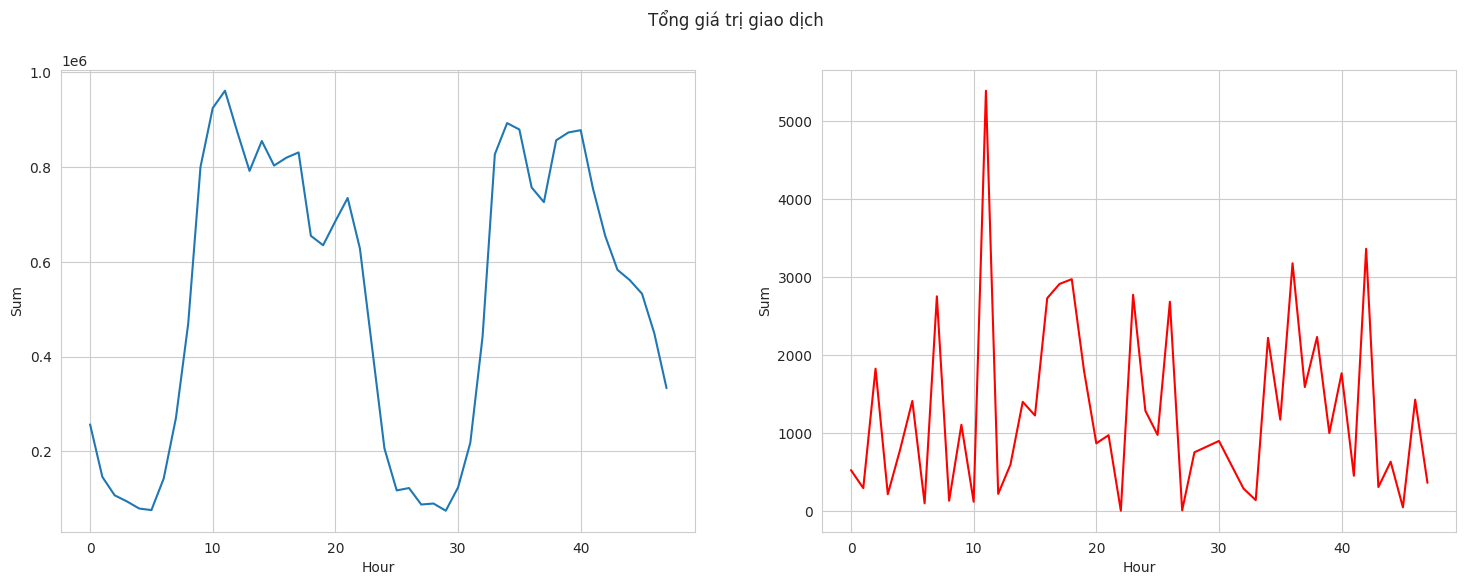

In [64]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Sum", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Sum", data=df.loc[df.Class==1], color="red")
plt.suptitle("Tổng giá trị giao dịch")
plt.show();

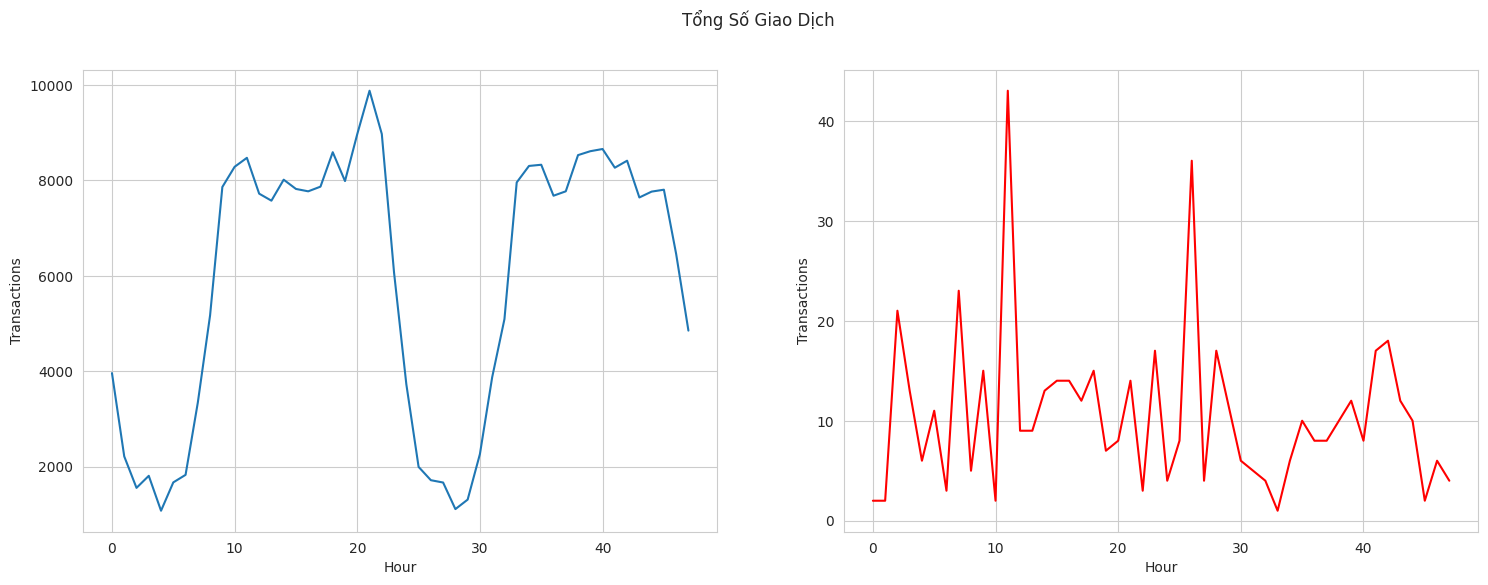

In [65]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Transactions", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Transactions", data=df.loc[df.Class==1], color="red")
plt.suptitle("Tổng Số Giao Dịch")
plt.show();

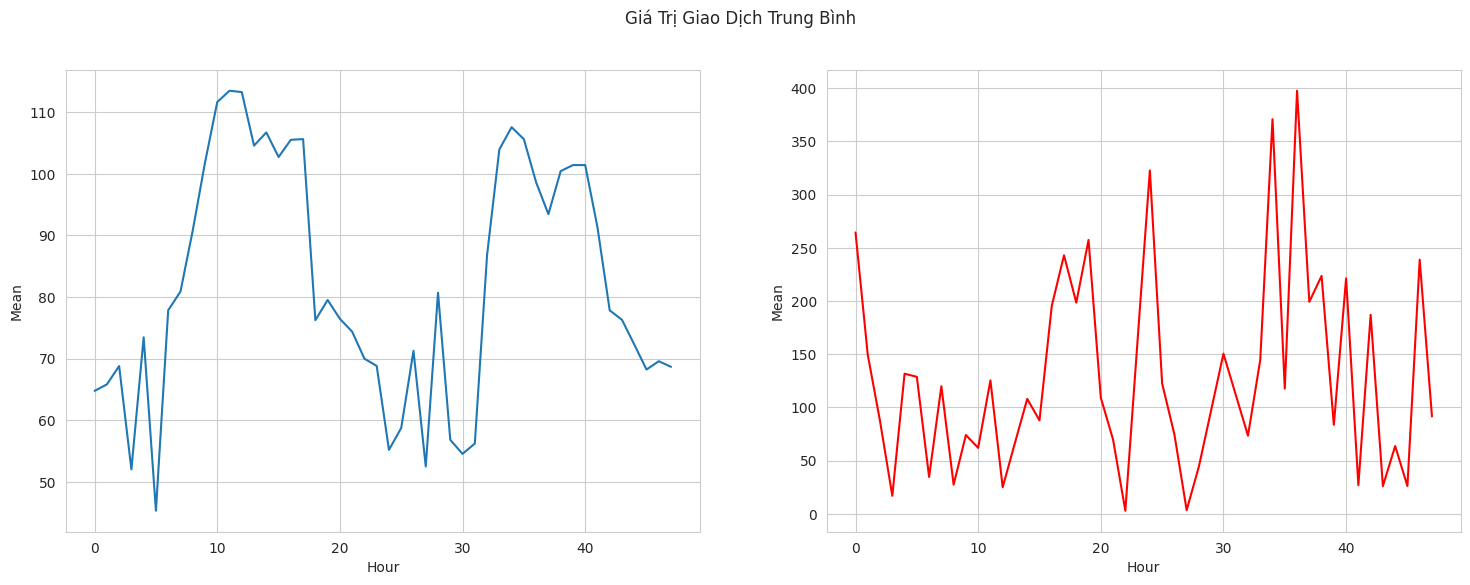

In [66]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Mean", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Mean", data=df.loc[df.Class==1], color="red")
plt.suptitle("Giá Trị Giao Dịch Trung Bình")
plt.show();

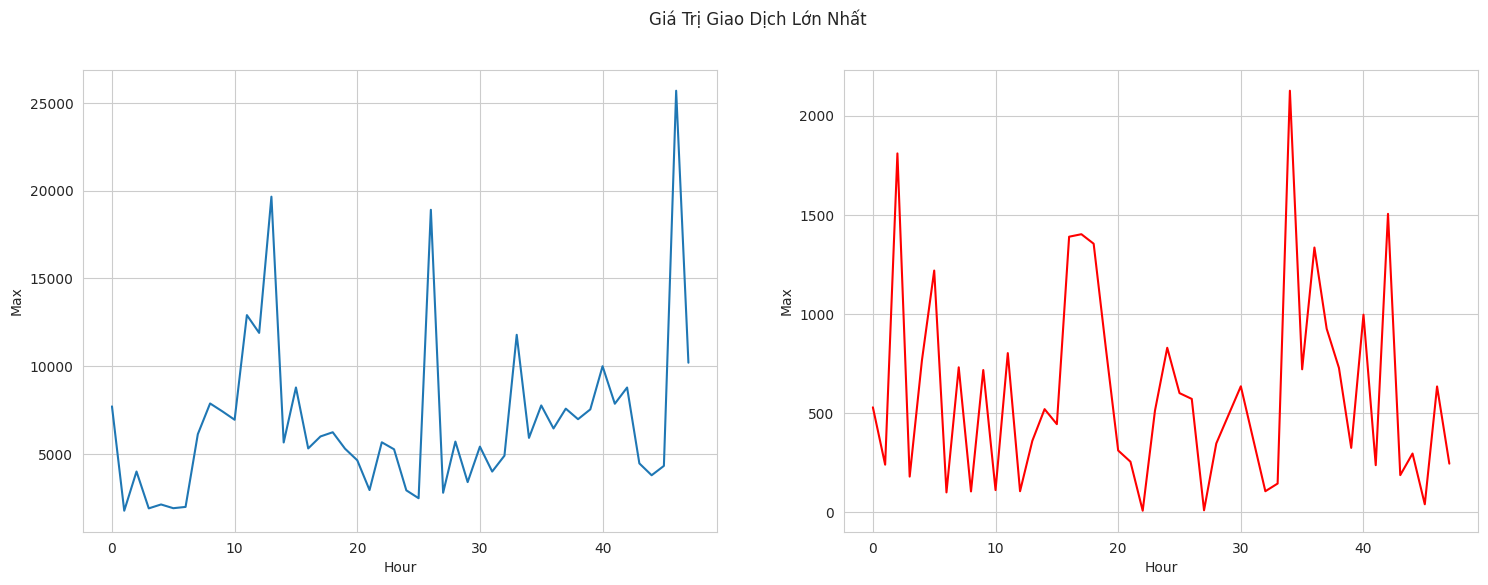

In [67]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Max", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Max", data=df.loc[df.Class==1], color="red")
plt.suptitle("Giá Trị Giao Dịch Lớn Nhất")
plt.show();

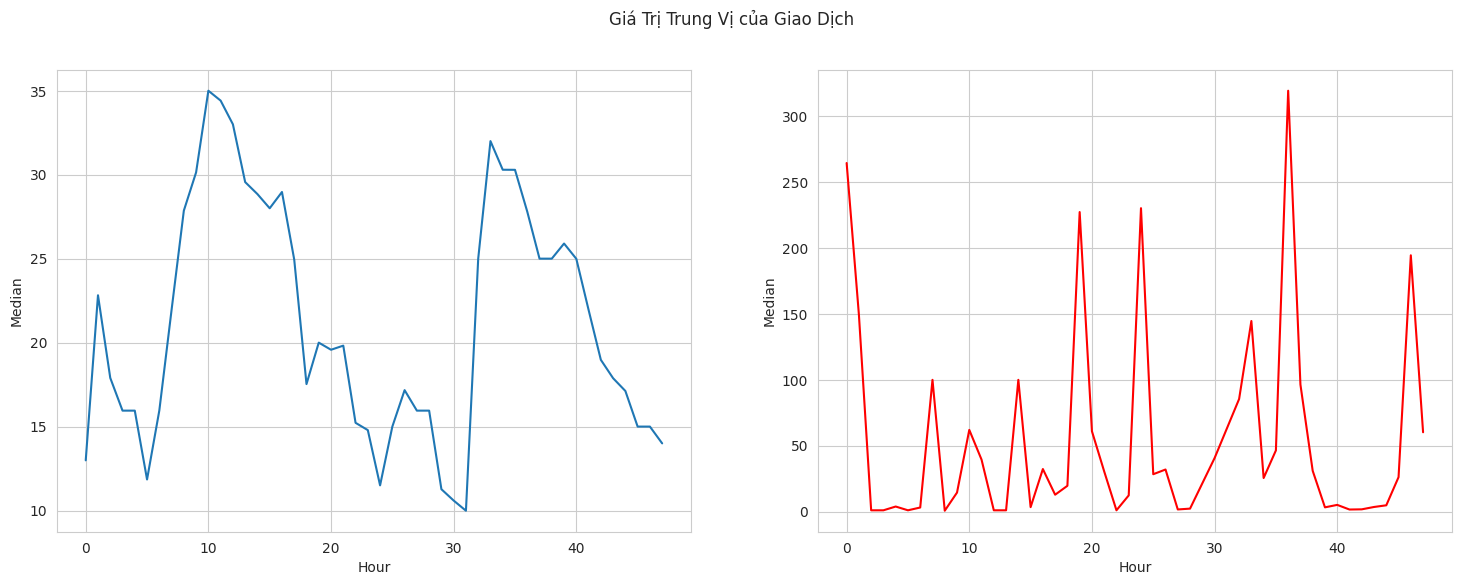

In [68]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Median", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Median", data=df.loc[df.Class==1], color="red")
plt.suptitle("Giá Trị Trung Vị của Giao Dịch")
plt.show();

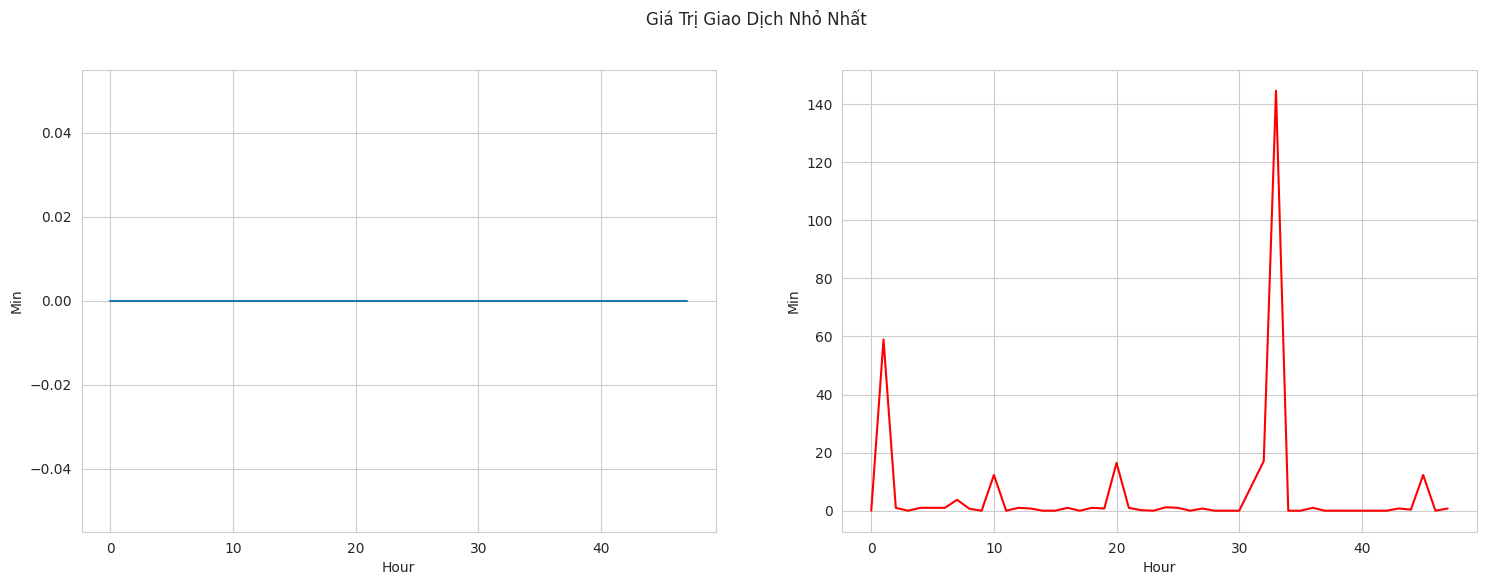

In [69]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Min", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Min", data=df.loc[df.Class==1], color="red")
plt.suptitle("Giá Trị Giao Dịch Nhỏ Nhất")
plt.show();

## Số tiền giao dịch

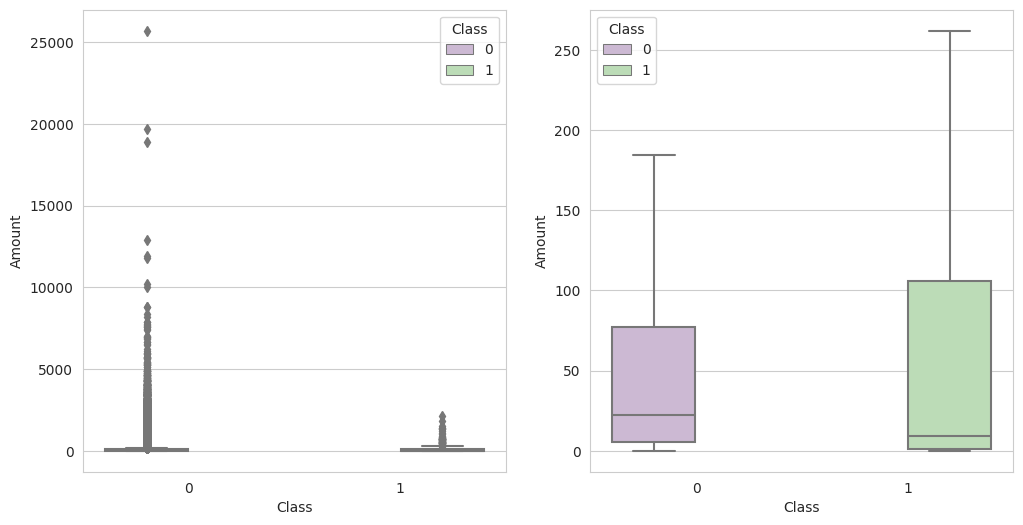

In [70]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=data_df, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="Class", y="Amount", hue="Class",data=data_df, palette="PRGn",showfliers=False)
plt.show();

In [71]:
tmp = data_df[['Amount','Class']].copy()
class_0 = tmp.loc[tmp['Class'] == 0]['Amount']
class_1 = tmp.loc[tmp['Class'] == 1]['Amount']
class_0.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [72]:
class_1.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [73]:
fraud = data_df.loc[data_df['Class'] == 1]

trace = go.Scatter(
    x = fraud['Time'],y = fraud['Amount'],
    name="Amount",
     marker=dict(
                color='rgb(238,23,11)',
                line=dict(
                    color='red',
                    width=1),
                opacity=0.5,
            ),
    text= fraud['Amount'],
    mode = "markers"
)
data = [trace]
layout = dict(title = 'Giá Trị Giao Dịch Gian Lận',
          xaxis = dict(title = 'Time [s]', showticklabels=True), 
          yaxis = dict(title = 'Amount'),
          hovermode='closest'
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='fraud-amount')

## Tương Quan Giữa Các Đặc Trưng

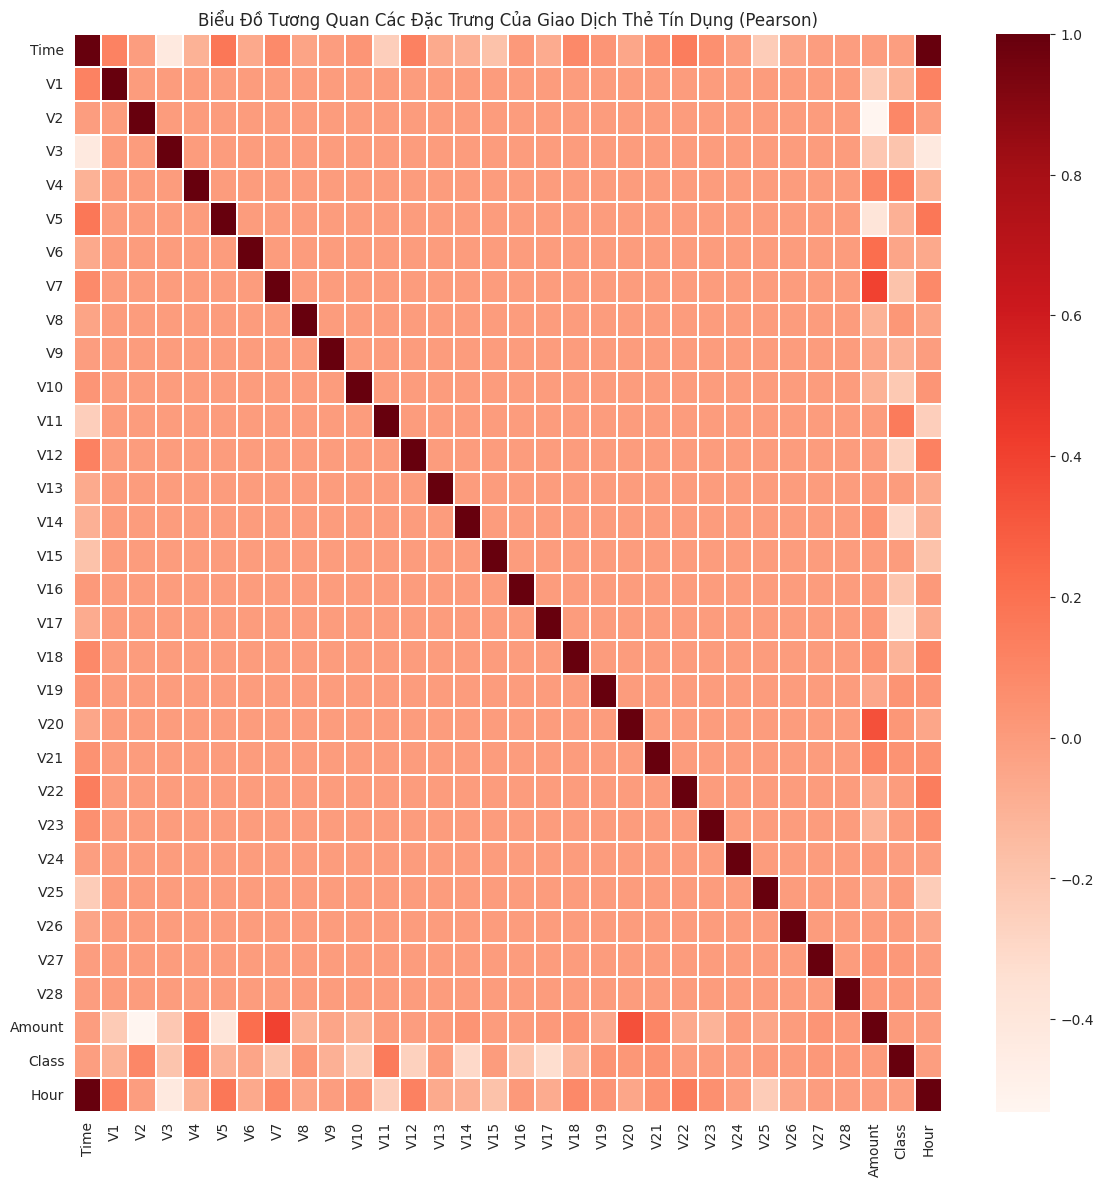

In [74]:
plt.figure(figsize = (14,14))
plt.title('Biểu Đồ Tương Quan Các Đặc Trưng Của Giao Dịch Thẻ Tín Dụng (Pearson)')
corr = data_df.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show()

Không có mối tương quan đáng kể nào giữa các đặc trưng V1–V28. Tuy nhiên, một số đặc trưng lại có tương quan nhất định với biến Time (tương quan nghịch với V3) và với biến Amount (tương quan thuận với V7 và V20, tương quan nghịch với V1 và V5).

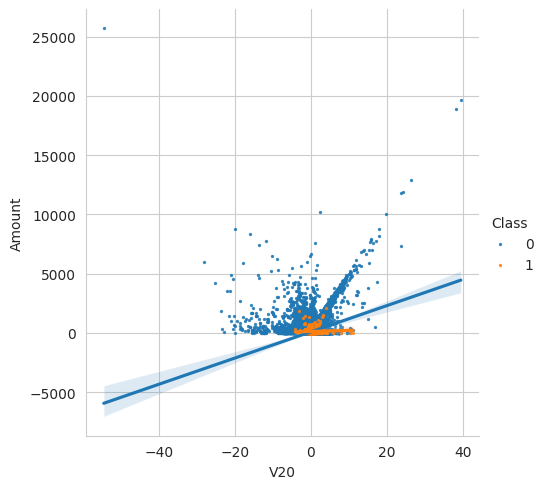

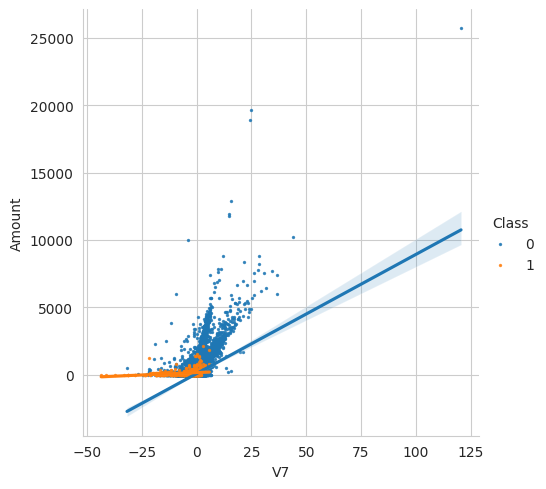

In [75]:
s = sns.lmplot(x='V20', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V7', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

Hai cặp đặc trưng này thực sự có tương quan (đường hồi quy của lớp Class = 0 có độ dốc dương, trong khi đường hồi quy của lớp Class = 1 cũng có độ dốc dương nhưng nhỏ hơn).

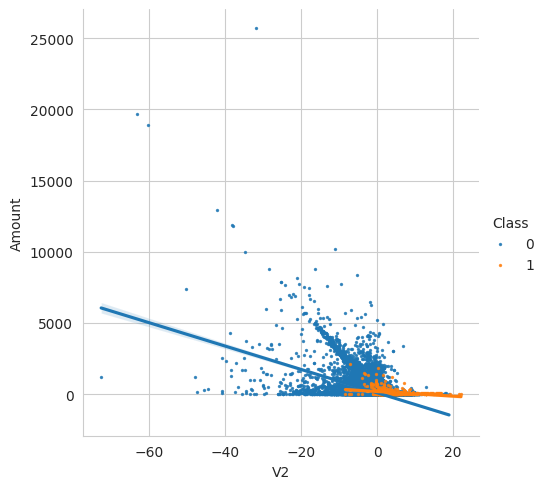

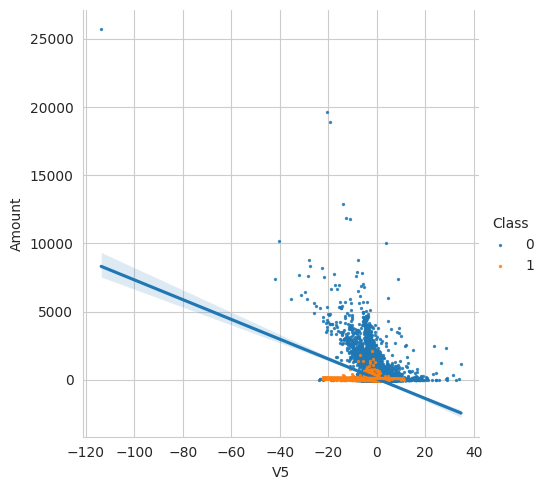

In [76]:
s = sns.lmplot(x='V2', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V5', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

Hai cặp đặc trưng này có tương quan nghịch (đường hồi quy của lớp Class = 0 có độ dốc âm, trong khi các đường hồi quy của lớp Class = 1 cũng có độ dốc âm nhưng rất nhỏ).

## Biểu Đồ Mật Độ Các Đặc Trưng

<Figure size 640x480 with 0 Axes>

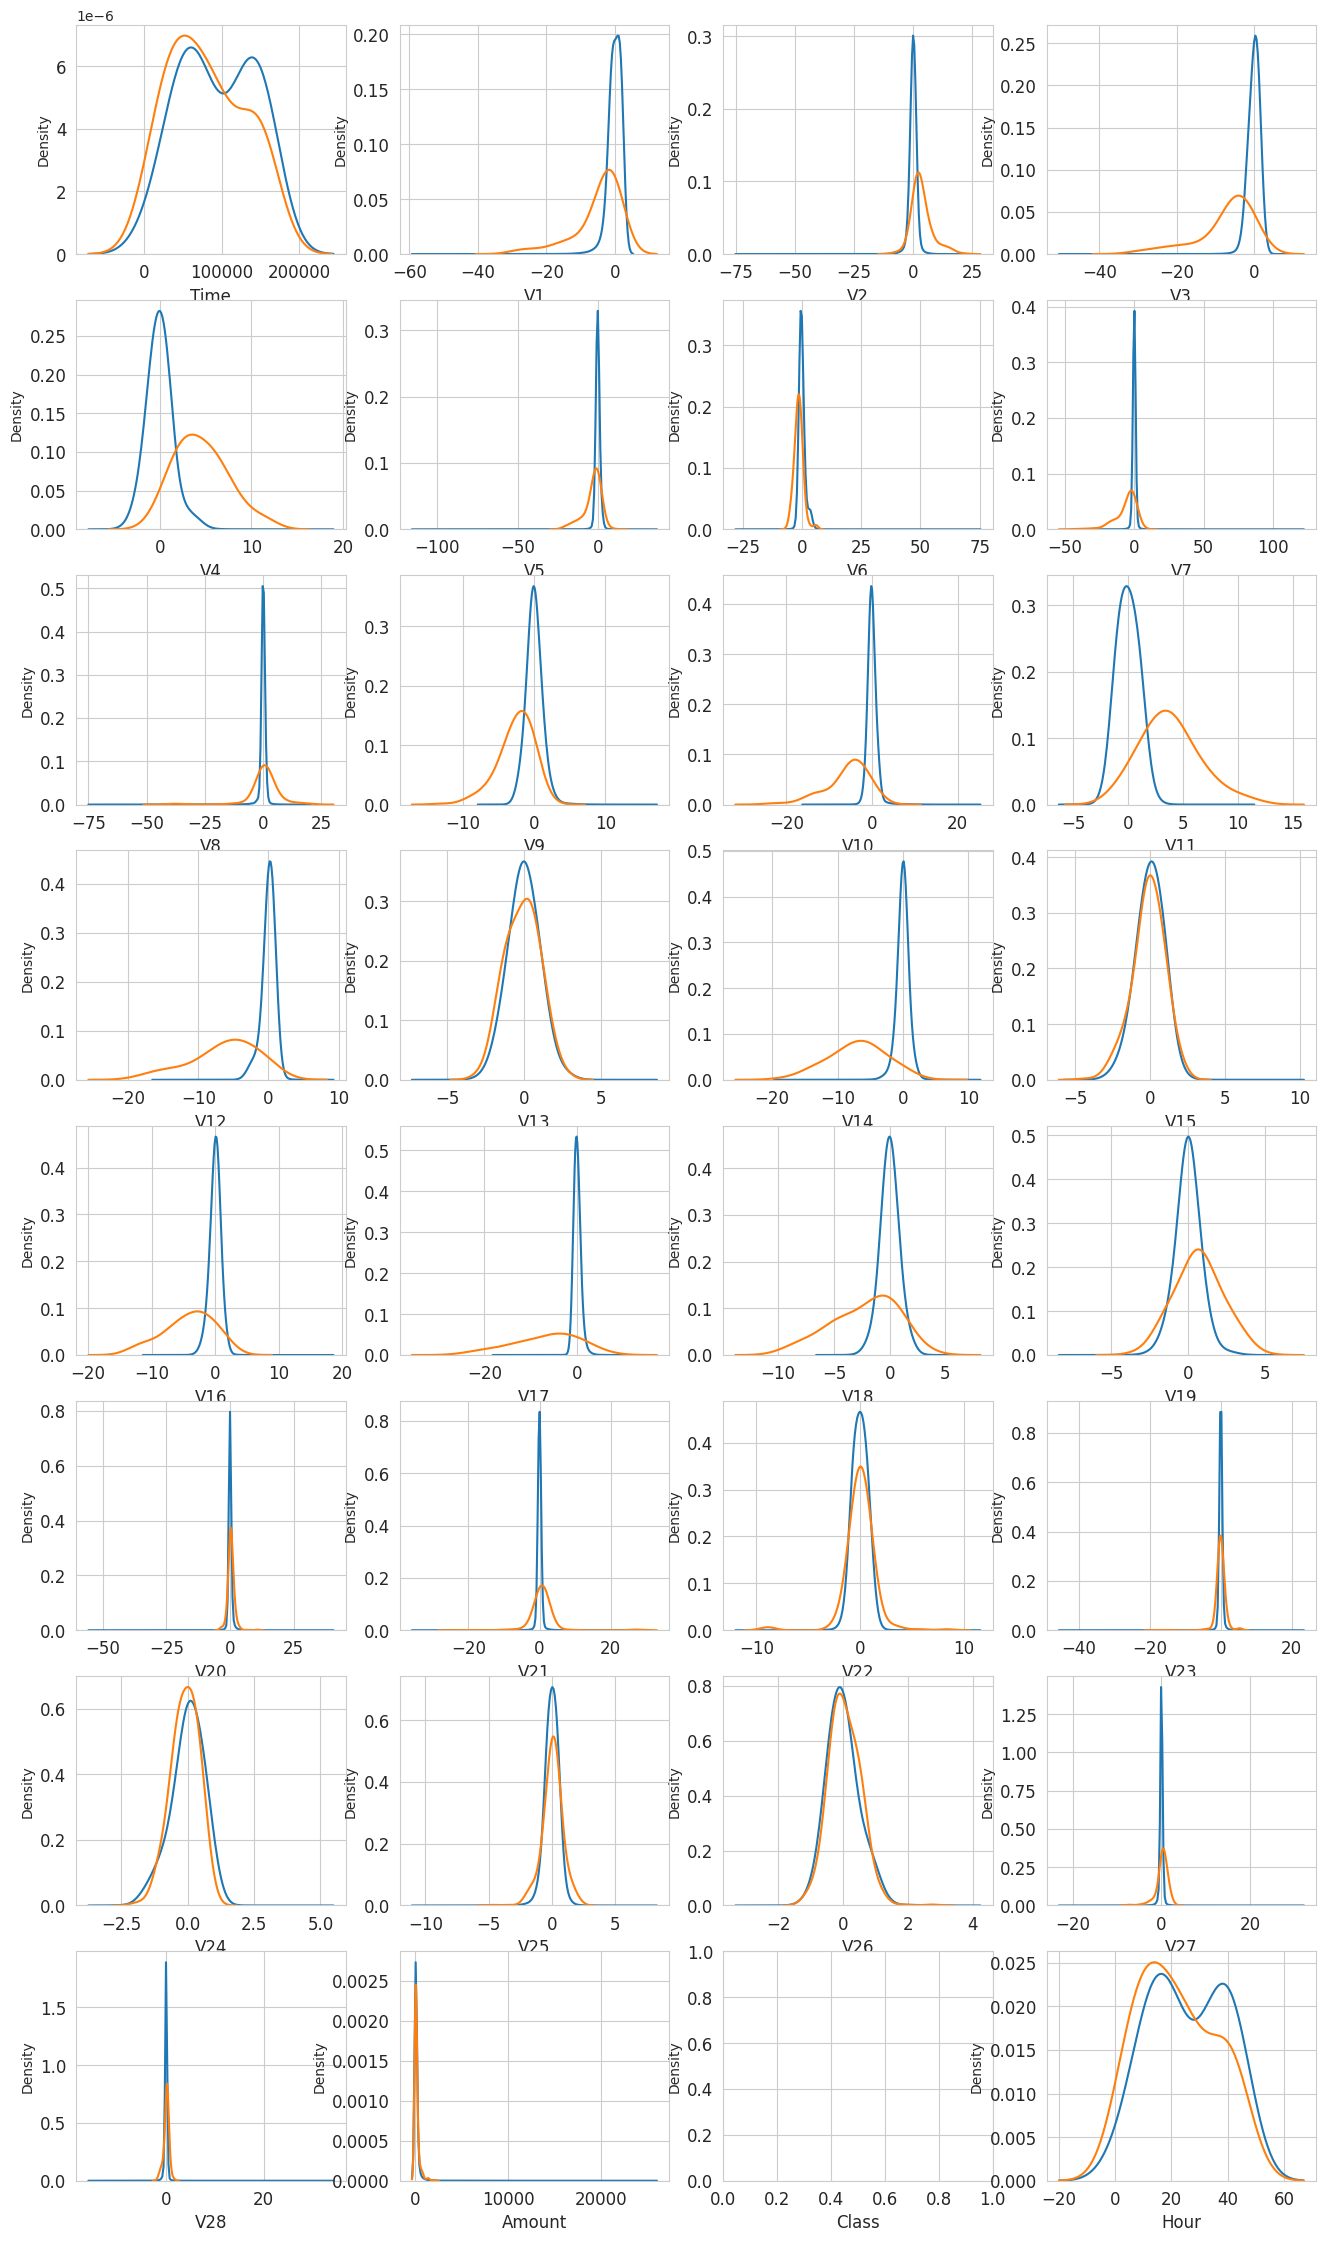

In [77]:
var = data_df.columns.values

i = 0
t0 = data_df.loc[data_df['Class'] == 0]
t1 = data_df.loc[data_df['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))

for feature in var:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(t0[feature], bw=0.5,label="Class = 0")
    sns.kdeplot(t1[feature], bw=0.5,label="Class = 1")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

Đối với một số đặc trưng, chúng ta có thể quan sát thấy mức độ phân tách khá tốt giữa hai giá trị của biến Class. Cụ thể, V4 và V11 có phân bố gần như tách biệt hoàn toàn giữa Class = 0 và Class = 1; các đặc trưng V12, V14, V18 được phân tách một phần; V1, V2, V3, V10 thể hiện dạng phân bố khá khác biệt; trong khi V25, V26, V28 lại có phân bố gần như giống nhau giữa hai lớp.

Nhìn chung, ngoại trừ một vài trường hợp như Time và Amount, phân bố của các đặc trưng đối với giao dịch hợp lệ (Class = 0) thường tập trung quanh giá trị 0, đôi khi có đuôi dài ở một phía. Ngược lại, các giao dịch gian lận (Class = 1) thường có phân bố nghiêng (không đối xứng).

# <a id="6">Các mô hình dự báo</a>  



### Xác định biến dự báo và biến mục tiêu

Hãy xác định các biến dự báo (predictors) và biến mục tiêu (target). Nếu có các biến phân loại (categorical), chúng cũng cần được chỉ định. Trong trường hợp này, bộ dữ liệu không có biến phân loại.

In [78]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

### Chia dữ liệu thành tập huấn luyện, kiểm định và kiểm tra

Bây giờ chúng ta sẽ chia dữ liệu thành các tập train, validation và test.

In [79]:
train_df, test_df = train_test_split(data_df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

## <a id="61">RandomForestClassifier</a>


### Xác định các tham số của mô hình

Chạy mô hình bằng cách sử dụng tập huấn luyện để đào tạo. Sau đó, sẽ dùng tập kiểm định (validation set) để đánh giá mô hình.

Tiêu chí đánh giá được sử dụng là GINI, với công thức:
 - GINI = 2 × AUC – 1
 - trong đó AUC là giá trị Receiver Operating Characteristic – Area Under Curve (ROC-AUC) 
<a href='#8'>[4]</a>.
Số lượng cây (estimators) được đặt là 100, và số lượng job chạy song song được đặt là 4.

In [80]:
forest_model = RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

In [81]:
forest_model.fit(train_df[predictors], train_df[target].values)
joblib.dump(forest_model, "forest_model.pkl")

['forest_model.pkl']

In [82]:
preds = forest_model.predict(valid_df[predictors])

### Mức Độ Quan Trọng của Các Đặc Trưng

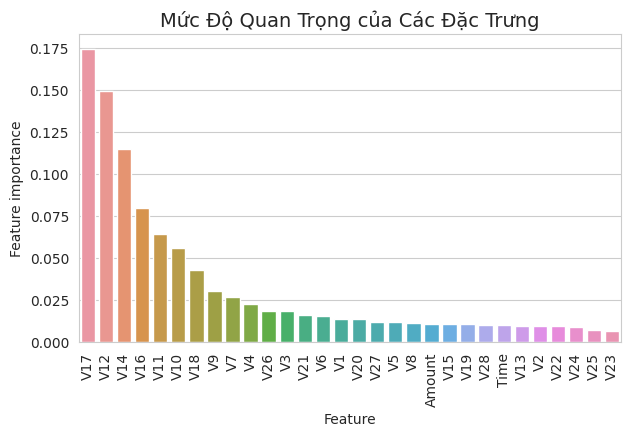

In [83]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': forest_model.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Mức Độ Quan Trọng của Các Đặc Trưng',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   


### Ma Trận Nhầm Lẫn (Confusion Matrix)

Hãy hiển thị ma trận nhầm lẫn cho các kết quả mà chúng ta đã thu được.

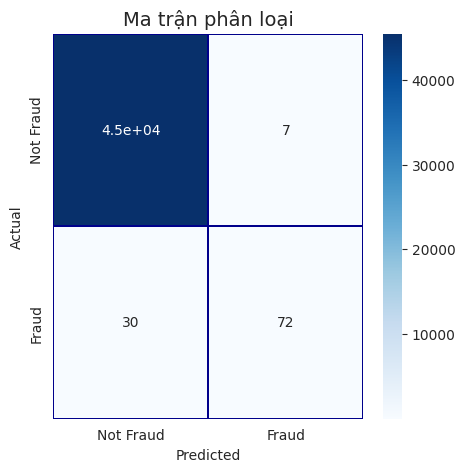

In [84]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Ma trận phân loại', fontsize=14)
plt.show()

### Lỗi Loại I và Lỗi Loại II

Chúng ta cần làm rõ rằng ma trận nhầm lẫn (confusion matrix) không phải là công cụ tốt để đánh giá mô hình trong trường hợp dữ liệu bị mất cân bằng nghiêm trọng. Trong những tình huống như vậy, chúng ta cần những chỉ số có thể đồng thời phản ánh tính chọn lọc (selectivity) và độ đặc hiệu (specificity) của phương pháp, nhằm giảm thiểu cả lỗi Loại I (Type I) và lỗi Loại II (Type II).

Giả thuyết không (H0) – Giao dịch không phải là gian lận.
Giả thuyết đối (H1) – Giao dịch là gian lận.

Lỗi Loại I – Bạn bác bỏ giả thuyết không trong khi H0 thực sự đúng.
→ Tức là bạn cho rằng giao dịch là gian lận trong khi nó thực ra là giao dịch hợp lệ.

Lỗi Loại II – Bạn không bác bỏ giả thuyết không trong khi H1 thực sự đúng.
→ Tức là bạn cho rằng giao dịch không gian lận trong khi nó thực ra là giao dịch gian lận.

Chi phí của Lỗi Loại I – Bạn nhầm lẫn cho rằng giao dịch là gian lận và từ chối một giao dịch hợp lệ.

Chi phí của Lỗi Loại II – Bạn nhầm lẫn cho rằng giao dịch không gian lận và chấp nhận một giao dịch gian lận.

Hình minh hoạ sau giải thích Lỗi Loại I và Lỗi Loại II:
<img src="https://i2.wp.com/flowingdata.com/wp-content/uploads/2014/05/Type-I-and-II-errors1.jpg" width="600"/>

✅ Ý nghĩa của hình minh họa

1️⃣ Type I Error (False Positive)

Bác sĩ kết luận sai rằng bệnh nhân có thai → trong khi thực tế không phải.

➡️ Hiểu theo bản chất:

 - Mô hình báo động có gian lận, nhưng thực tế không có gian lận.
 - Bác sĩ bác bỏ giả thuyết không (H0: không có thai) khi H0 đúng.

📌 Ví dụ thực tế trong Fraud Detection: Ngân hàng chặn nhầm giao dịch hợp lệ → gây phiền cho khách hàng.

2️⃣ Type II Error (False Negative)

Bác sĩ kết luận sai rằng bệnh nhân không có thai → trong khi thực tế có thai.

➡️ Hiểu theo bản chất:

 - Mô hình không phát hiện gian lận, nhưng thực tế có gian lận.
 - Bác sĩ không bác bỏ giả thuyết không (H0) trong khi H1 mới đúng.

📌 Ví dụ thực tế trong Fraud Detection:
Ngân hàng bỏ sót giao dịch gian lận → gây thiệt hại tài chính.

💡 Ứng dụng trong mô hình phát hiện gian lận

 - Type I → từ chối nhầm giao dịch hợp lệ → gây phiền khách nhưng ít thiệt hại.
 - Type II → bỏ lọt giao dịch gian lận → thiệt hại tài chính lớn.

➡️ Vì thế, trong fraud detection, giảm lỗi Loại II thường quan trọng hơn.


In [85]:
roc_auc_score(valid_df[target].values, preds)

0.8528641975628091

## <a id="62">AdaBoostClassifier</a>


AdaBoostClassifier là viết tắt của Adaptive Boosting Classifier <a href='#8'>[5]</a>.
### Chuẩn bị mô hình


In [86]:
ada_model = AdaBoostClassifier(random_state=RANDOM_STATE,
                         algorithm='SAMME.R',
                         learning_rate=0.8,
                             n_estimators=NUM_ESTIMATORS)

### Huấn luyện mô hình


In [87]:
ada_model.fit(train_df[predictors], train_df[target].values)
joblib.dump(ada_model, "ada_model.pkl")

['ada_model.pkl']

### Dự đoán giá trị mục tiêu


In [88]:
preds = ada_model.predict(valid_df[predictors])

### Mức độ quan trọng của các đặc trưng


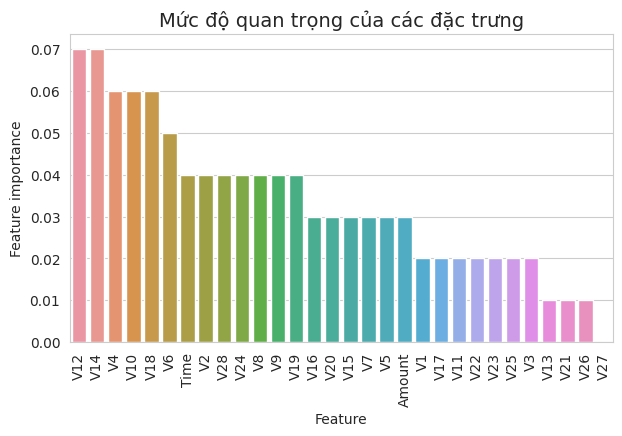

In [89]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': ada_model.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Mức độ quan trọng của các đặc trưng',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

### Ma Trận Nhầm Lẫn


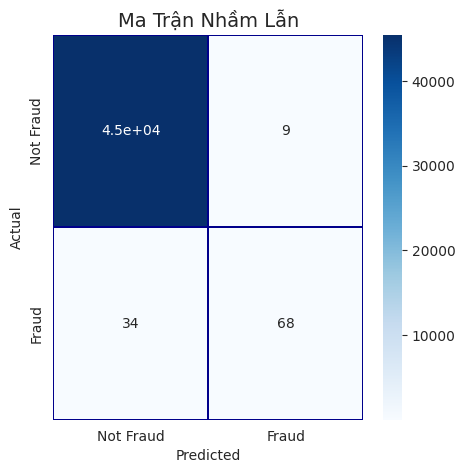

In [90]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Ma Trận Nhầm Lẫn', fontsize=14)
plt.show()

### Area under curve

In [91]:
roc_auc_score(valid_df[target].values, preds)

0.8332343604519027

## <a id="63">CatBoostClassifier</a>


CatBoostClassifier là một thuật toán gradient boosting cho cây quyết định, có khả năng xử lý hiệu quả các dữ liệu dạng phân loại (categorical data) <a href='#8'>[6]</a>.
### Chuẩn bị mô hình


In [92]:
cat_model = CatBoostClassifier(iterations=500,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='AUC',
                             random_seed = RANDOM_STATE,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = VERBOSE_EVAL,
                             od_wait=100)

In [93]:
cat_model.fit(train_df[predictors], train_df[target].values,verbose=True)

0:	total: 447ms	remaining: 3m 42s
50:	total: 18.6s	remaining: 2m 43s
100:	total: 36.1s	remaining: 2m 22s
150:	total: 53s	remaining: 2m 2s
200:	total: 1m 9s	remaining: 1m 43s
250:	total: 1m 26s	remaining: 1m 25s
300:	total: 1m 43s	remaining: 1m 8s
350:	total: 1m 59s	remaining: 50.9s
400:	total: 2m 17s	remaining: 34s
450:	total: 2m 35s	remaining: 16.9s
499:	total: 2m 51s	remaining: 0us


### Dự đoán giá trị mục tiêu


In [94]:
preds = cat_model.predict(valid_df[predictors])
joblib.dump(cat_model, "cat_model.pkl")

['cat_model.pkl']

### Mức Độ Quan Trọng của Các Đặc Trưng


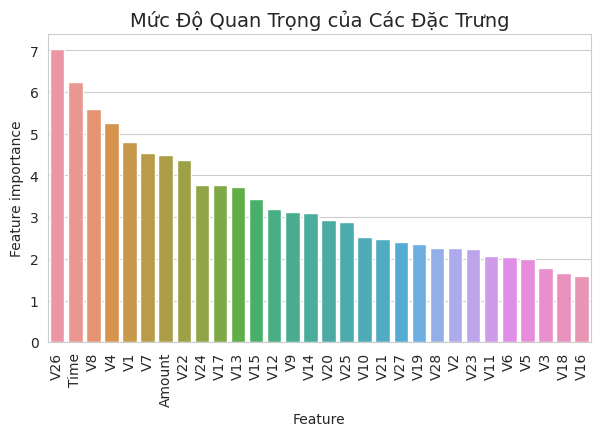

In [95]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': cat_model.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Mức Độ Quan Trọng của Các Đặc Trưng',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

### Ma Trận Phân Loại (Confusion Matrix)


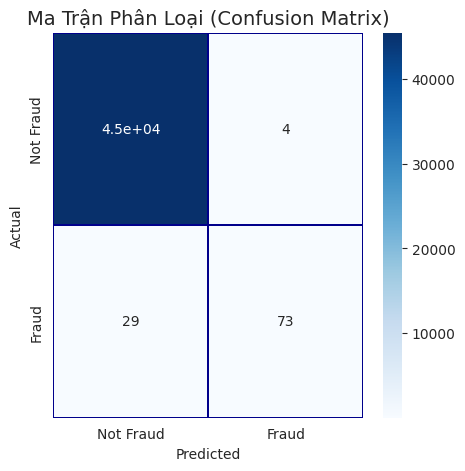

In [96]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Ma Trận Phân Loại (Confusion Matrix)', fontsize=14)
plt.show()

In [97]:
roc_auc_score(valid_df[target].values, preds)

0.8577991493075996